# 📘 DIS Midterm - Fall 2022

**🎉 Welcome to DIS Midterm that takes place on the 27th of Octomber 2022 from 12:15 to 13:00.**

> Please fill the following info:
> - Your Name: Arina Rak
> - Your SCIPER: 330939	

### 💡 THE BACKSTORY

You are an engineer working in the sports news articles website: _allaboutsports.ch_ . The editors' team of this news portal wants to create a piece for the upcoming Summer Olympic Games for the swimming Olympic medalist Katie Ledecky. To do so, they want to collect information not only from the news coverage but also from what is being said about her on social media. Therefore, you are using the Twitter data that have have the hashtag of _#allaboutsportsch_ news portal to find relevant to the athlete tweets that will help the editors.


### 🐦 THE DATA

The collected tweets are stored into the `allaboutsports_tweets.csv` which contains the following columns:

| Column     | Description                   |
|------------|-------------------------------|
| **id**     | The id of the tweet           |
| **tweet**  | The text/content of the tweet |
| **relevant**  | Gold labels for retrieval model evaluation in Part 5 |


### ✅ THE TASK

Build a retrieval system that searches the tweets and retrieve the ones that talk about Katie Ledecky.

You will test a Vector Space retrieval model and a Probabilistic model, and you will compare their results & performance.

## Answer all the parts of the midterm:

- [PART 0: Rename your notebook with your SciperNo](#part0)

- [PART 1: Parse and understand the data](#part1)
    - 1.1 Create the vocabulary of the documents/tweets
    - 1.2 Print the 5 most frequent words present in the tweets

- [PART 2: Encode documents with Vector Space Retrieval](#part2)
    - 2.1 Build the document-frequency matrix.
    - 2.2 Build the inverse document-frequency matrix
    - 2.3 Vectorize input with Vector Space Model
    
- [PART 3: Encode documents with Probabilistic Retrieval](#part3)
    - 3.1 Compute collection probabilities for each document
    - 3.2 Implement query-document likelohood

- [PART 4: Retrieve documents](#part4)
    - 4.1 Retrieve documents with Vector Space Retrieval 
    - 4.2 Retrieve documents with Probabilistic retrieval

- [PART 5: Evaluate your retrieval system](#part5)
    - 5.1 Discuss the precision and recall between the Vector Space and Probabilistic Retrieval
    - 5.2 Explain the role of k in retrieval performance
    - 5.3 Explain the role of lambda in the Probabilistic retrieval performance

# 🍀 GOOD LUCK 🍀

<a id='part0'></a>
## PART 0: Rename your notebook with your SciperNo

The final sumbitted file should have the following name: `SciperNo.ipynb`

<a id='part1'></a>
## PART 1: Parse and understand the data

In [6]:
# Import libraries- you can additionally import any library you want.
import pandas as pd
import numpy as np
from collections import Counter
import math
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from functools import reduce
nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arinaruck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/arinaruck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Utility functions - Nothing to change here.
stemmer = PorterStemmer()
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return [word.lower() for word in tokens if word not in stopwords.words('english')]

def preprocess_text(documents):
    docs = list()
    for doc in documents:
        docs.append(tokenize(doc))  # tokenize
    return docs

In [8]:
# Read the data
tweets = pd.read_csv('allaboutsports_tweets.csv')

# Clean the data
tweets['clean_tweet'] = preprocess_text(tweets['tweet'].tolist())
len(tweets)

50

> #### 1.1 Create the vocabulary of the documents/tweets.

In [9]:
from collections import defaultdict

In [10]:
def get_vocabulary_frequency(documents):
    """
    It parses the input documents and creates a dictionary with the terms and term frequencies.
    
    INPUT:
    Doc1: hello hello world
    Doc2: hello friend
    
    OUTPUT:
    {'hello': 3,
    'world': 1,
    'friend': 1}

    :param documents: list of list of str, with the tokenized tweets.
    :return: dict, with keys the words and values the frequency of each word.
    """
    vocabulary = defaultdict(int)
    for doc in documents:
        for word in doc:
            vocabulary[word] += 1
    return dict(vocabulary)

In [11]:
voc = get_vocabulary_frequency(tweets['clean_tweet'].tolist())
len(voc)

412

> #### 1.2 Print the 5 most frequent words present in the tweets.
> Use the vocabulary frequencies you created in the previous question to find the top-5 words/terms.

In [13]:
voc_sorted = sorted(voc.items(), key=lambda x: x[1], reverse=True)
voc_sorted[:5]

[('allaboutsportsch', 50),
 ('federer', 18),
 ('roger', 15),
 ('olympic', 10),
 ('paris', 9)]

<a id='part2'></a>
## PART 2: Encode documents with Vector Space Retrieval

In this part we will encode/vectorize the documents using the **Vector Space Model**. 
More specifically:
- we will compute the term-frequency matrix **(tf)**
- we will compute the inverse document frequency **(idf)**
- we will vectorize/encode the tweets with **tf-idf**
- we will implement the **cosine similarity**

> #### 2.1 Build the term-frequency matrix

In [19]:
def get_tf(documents, vocabulary):
    """
    It creates the term-frequency matrix with rows the terms of the vocabulary and columns the number of documents.
    Each value of the matrix represents the frequency (normalized to document max frequecy) of a term (row) 
    in a document (column).
    
    Example:
    
    > INPUT:
    documents:
    Doc1: hello hello world
    Doc2: hello friend
    
    voc: 
    [hello, world, friend]
    
    > OUPUT:    
    [[1, 1],
    [0.5, 0],
    [0, 1]]
    
    :param documents: list of list of str, with the tokenized tweets.
    :param vocabulary: dict with the vocabulary (computed in 1.1) and each term's frequency.
    :return: np.array with the document-term frequencies
    """
    document_term_freq = np.zeros(shape=(len(vocabulary), len(documents)))
    voc_to_idx = {term: idx for idx, term in enumerate(vocabulary)}
    for j, doc in enumerate(documents):
        for word in doc:
            document_term_freq[voc_to_idx[word], j] += 1
        document_term_freq[:, j] /= document_term_freq[:, j].max()
    return document_term_freq

In [21]:
#test tf
tf = get_tf([['hello', 'hello', 'world'], ['hello', 'friend']], ['hello', 'world', 'friend'])
print(tf)

[[1.  1. ]
 [0.5 0. ]
 [0.  1. ]]


In [22]:
tf = get_tf(tweets['clean_tweet'].tolist(), voc)
tf.shape

(412, 50)

> #### 2.2 Build the inverse document-frequency matrix (idf)

In [23]:
def get_idf(documents, vocabulary):
    """
    It computes IDF scores, storing idf values in a dictionary.
    
    :param documents: list of list of str, with the tokenized tweets.
    :param vocabulary: dict with the vocabulary (computed in 1.1) and each term's frequency.
    :return: dict with the terms as keys and values the idf for each term.
    """
    idf = dict()
    log_base = math.e
    num_documents = len(documents)
    log_num_documents = math.log(num_documents, log_base)
    for i, term in enumerate(vocabulary):
        n_term_docs = sum([1 if term in doc else 0 for doc in documents])
        idf[term] = log_num_documents - math.log(n_term_docs, log_base) 
    return idf

In [24]:
idf = get_idf(tweets['clean_tweet'].tolist(), voc)
len(idf)

412

In [25]:
idf['katie']

2.120263536200091

#### Vectorization of input with the Vector Space Model

In [26]:
def vectorize_vsr(document, vocabulary, idf):
    """
    It takes the input text and vectorizes it based on the tf-idf formula.
    
    :param document: list of str, with the tokenized tweet
    :param vocabulary: dict, with the vocabulary (computed in 1.1) and each term's frequency.
    :param idf: dict, with the terms as keys and values the idf for each term.
    :return: np.array, with the vectorized tweet
    """
    vector = np.zeros(len(vocabulary))
    term_freq = Counter(document)
    max_freq = term_freq.most_common(1)[0][1]
    for i, term in enumerate(vocabulary):
        vector[i] = idf[term] * term_freq[term]/max_freq
    return vector

In [27]:
vectorized_documents = np.array([vectorize_vsr(doc, voc, idf) for doc in tweets['clean_tweet'].tolist()])
vectorized_documents.shape

(50, 412)

#### Cosine similarity for Vector Space Retrieval 

In [28]:
def cosine_similarity(v1,v2):
    """
    It computes cosine similarity.
    
    :param v1: list of floats, with the vector of a document.
    :param v2: list of floats, with the vector of a document.
    :return: float
    """
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
        sim = 0
    else:
        sim = sumxy/math.sqrt(sumxx*sumyy)
    return sim

<a id='part3'></a>
## PART 3: Encode documents with Probabilistic Retrieval

In this part we will encode/vectorize the documents using the **Probabilistic Model**. 
More specifically:
- we will compute the collection probabilities for each term **($P(t|M_c)$)**
- we will copute the query-document likelihood **$P(t_i|document)$** for each query term $t_i$

> #### 3.1 Compute collection probabilities $P(t|M_c$) for each document

In [36]:
def get_collection_prob(vocabulary):
    """
    Computes the collection probabilities of each term present in the documents/tweets.
    
    :param vocabulary: dict with the vocabulary (computed in 1.1) and each term's frequency.
    :return: dict with the collection probabilities for each term in the vocabulary.
    """
    probs = dict()
    total_freq = sum(vocabulary.values())
    for term in vocabulary:
        probs[term] = vocabulary[term] / total_freq
    return probs

In [37]:
p_Mc = get_collection_prob(voc)
len(p_Mc)

412

> #### 3.2 Implement query-document likelihood $P(q|doc)$

In [43]:
def compute_query_likelihood(query, document, p_Mc, l):
    """
    It computes the probability of a query given a document/tweet.
    
    :param query: np.array with the tokenized query
    :param document: np.array with the tokenized document
    :param p_Mc: dict with the collection probabilities for each term in the vocabulary.
    :param l: float, smoothing variable lambda.    
    :return: float with the query-document likelihood
    """
    doc_len = len(document)
    tf_q = np.zeros(len(query))
    mc_q = np.zeros(len(query))
    for i, t in enumerate(query):
        for w in document:
            if t == w:
                tf_q[i] += 1
        mc_q[i] = p_Mc[t]
    p_t = l * (tf_q / doc_len) + (1 - l) * mc_q
    prob = p_t.prod()
    return prob


<a id='part4'></a>
## PART 4: Retrieve documents

In this part, we will apply both **Vector Space Retrieval** and **Probabilistic retrieval** in order to get the relevant tweets to Katie Ledecky athlete. 

> There is nothing to implement in this part, however, you should run the following cells and test your implementation in Parts 2&3.

In [39]:
query = ["katie","ledecky","athlete"]
doc_ids = tweets['id'].tolist()

#### Retrieves with Vector Space Retrieval for `query = "Katie Ledecky"` and prints the top 10 relevant documents

In [40]:
# vectorize query and tweets
vectorized_documents_vsr =  np.array([vectorize_vsr(doc, voc, idf) for doc in tweets['clean_tweet'].tolist()])
vectorized_query_vsr = np.array(vectorize_vsr(query, voc, idf))

# performs vector space retrieval
scores = dict()
for idx, doc_vec in zip(doc_ids, vectorized_documents_vsr):
    scores[idx] = cosine_similarity(doc_vec, vectorized_query_vsr)

In [41]:
# Print top 5 retrieved tweets
retrieved_tweets_vsr = pd.DataFrame(list(reversed(sorted(scores.items(), key=lambda item: item[1]))),
                                    columns=['id', 'score'])
retrieved_tweets_vsr[:10]

,id,score
0,1,0.578184
1,4,0.319205
2,2,0.305536
3,6,0.295565
4,5,0.282030
5,3,0.203919
6,7,0.186898
7,45,0.138721
8,12,0.118039
9,50,0.000000


#### Retrieve with Probabilistic Retrieval for `query = "Katie Ledecky"` and prints the top 10 relevant along with their probability (score).

In [46]:
# performs probabilistic retrieval
probs = dict()
for idx, doc in zip(doc_ids, tweets['clean_tweet'].tolist()):
    probs[idx] = compute_query_likelihood(query, doc,  p_Mc, 0.25)

In [47]:
# Print top 5 retrieved tweets
retrieved_tweets_prob = pd.DataFrame(list(reversed(sorted(probs.items(), key=lambda item: item[1]))),
                                     columns=['id', 'score'])
retrieved_tweets_prob[:10]            

,id,score
0,1,1.120750e-04
1,6,8.671462e-06
2,2,8.671462e-06
3,4,6.973367e-06
4,5,5.655183e-06
5,3,4.244771e-06
6,7,1.829378e-06
7,45,1.437455e-06
8,12,1.437455e-06
9,50,2.616858e-07


<a id='part5'></a>
## PART 5: Evaluate retrieval

In this part, we will evaluate both retrieval systems and discuss the impact of lambda value as well as the number of retrieved documents.

We are now going to use the column `'relevant'` in the dataset. It is referring to whether the tweet is relevant to the query or not. We define this column as the 'oracle' that in an ideal scenario knows which tweets are relevant for Katie Ledecky and which are not.
Based on this, we will compute the performance of the retrieval systems we built. 🎉

#### Precision@k & Recall@k

In [48]:
def compute_precision_at_k(retrieved_tweets, gt, k=5):
    """
    It computes the precision score at a defined set of retrieved documents (k).
    
    :param predict: list of predictions
    :param gt: list of actual relevant data
    :param k: int
    :return: float, the precision at a given k
    """
    results = retrieved_tweets.merge(gt, how="outer", on="id")
    return np.array(results[:k]['relevant'].tolist()).mean()

def compute_recall_at_k(retrieved_tweets, gt, k=5):
    """
    It computes the recall score at a defined set of retrieved documents (k).
    
    :param predict: list of predictions
    :param gt: list of actual relevant data
    :param k: int
    :return: float, the precision at a given k
    """
    relevant = len(tweets[tweets['relevant']==1])
    results = retrieved_tweets.merge(gt, how="outer", on="id")[:k]
    hits = len(results[results['relevant']==1])
    return hits / relevant

> #### 5.1 Discuss the difference in performance between the Vector Space and Probabilistic Retrieval based on the Precision and Recall scores in the provided table.

In [64]:
vsr_precision = compute_precision_at_k(retrieved_tweets_vsr, tweets[['id', 'relevant']], 5)
prob_precision = compute_precision_at_k(retrieved_tweets_prob, tweets[['id', 'relevant']], 5)

vsr_recall = compute_recall_at_k(retrieved_tweets_vsr, tweets[['id', 'relevant']], 5)
prob_recall = compute_recall_at_k(retrieved_tweets_prob, tweets[['id', 'relevant']], 5)

In [65]:
vsr_precision = compute_precision_at_k(retrieved_tweets_vsr, tweets[['id', 'relevant']], 5)
prob_precision = compute_precision_at_k(retrieved_tweets_prob, tweets[['id', 'relevant']], 5)

vsr_recall = compute_recall_at_k(retrieved_tweets_vsr, tweets[['id', 'relevant']], 5)
prob_recall = compute_recall_at_k(retrieved_tweets_prob, tweets[['id', 'relevant']], 5)

pd.DataFrame([('Vector Space Retrieval', vsr_precision, vsr_recall),
              ('Probabilistic Retrieval',prob_precision, prob_recall)], 
             columns=['Model', 'Precision@5', 'Recall@5']).round(3)

,Model,Precision@5,Recall@5
0,Vector Space Retrieval,1.0,0.833
1,Probabilistic Retrieval,1.0,0.833


**➡️ PLEASE WRITE YOUR ANSWER HERE**


I got the same precision and recall for both models. Even though the ranking of the top-5 documents is different, they both retrieve the same set of the top-5 documents (which also appears to be the correct one)
Even though the model retrieve the right documents, there is no significant decrease of the similarity score after the top-6 correct documents. This means that the scores themselves (the absolute values) are not very representative and only the ranking matters.
The recall value is also understandable, since one of the relevant documents was not retrieved (since there are more than 5)

> #### 5.2 Discuss the following plot regarding the impact of the $k$ variable in the Precision@k metric.

In [54]:
ks = [1, 5, 10, 15]

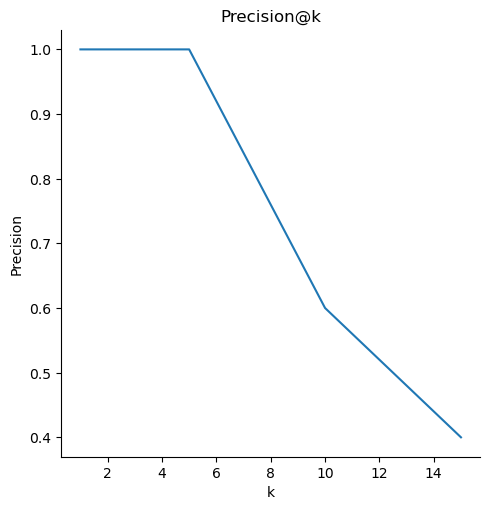

In [55]:
# run Probabilistic Retrieval and evaluate it on different k
res = list()
for k in ks:
    res.append({'Precision': compute_precision_at_k(retrieved_tweets_prob, tweets[['id', 'relevant']], k),
                'k': k})
                
res_df = pd.DataFrame(res)
sns.relplot(data=res_df, x="k", y="Precision", kind="line").set(title='Precision@k')

In [56]:
tweets[['relevant']].sum()

relevant    6
dtype: int64

**➡️ PLEASE WRITE YOUR ANSWER HERE**

Since there are only 6 relevant documents in the corpus, the precision @ k can not maintain the value 1 if k is higher than 6.

The fact that the model has precision of 1 for k: 1-6 means that it's done the ranking the best way possible (assuming we do not have any preference between the relevant documents)

> #### 5.3 Discuss the following plot regarding the impact of the $\lambda$ (lambda) in the query-document likelihood probability $P(q|Doc)$.

In this example we estimate the likehood for a given query and a given tweet (see below). The $P(t|M_c)$ values are the same as in the rest of the notebook and are calculated based on the whole document collection. 

In [58]:
new_query = ["katie","ledecky","swimmer"]
a_document= tweets['clean_tweet'].tolist()[3]

print('The query: "{}""'.format(' '.join(new_query)))
print('Tweet: "{}"'.format(tweets['tweet'].tolist()[3]))

The query: "katie ledecky swimmer""
Tweet: "Is Katie Ledecky competing in the 2024 Paris Olympics? #allaboutsportsch"


     Likelihood  lambda
0  1.550731e-07    0.00
1  1.743342e-06    0.25
2  3.523362e-06    0.50
3  3.580470e-06    0.75
4  0.000000e+00    1.00


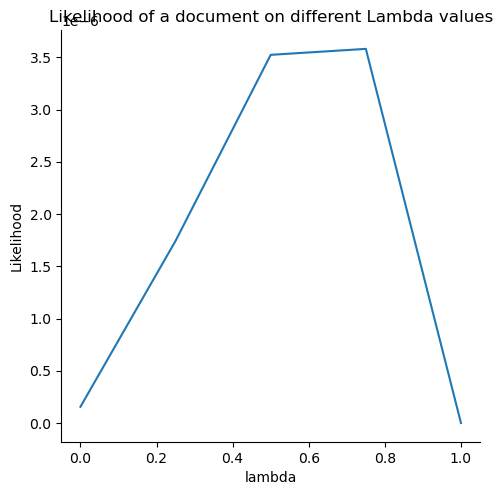

In [60]:
# for each lambda get the query-document likehood estimation.
lambdas = [0, 0.25, 0.5, 0.75, 1]
probabilities = list()
for l in lambdas:
    probabilities.append({'Likelihood': compute_query_likelihood(new_query, a_document,  p_Mc, l),
                         'lambda': l})

res_df = pd.DataFrame(probabilities)
print(res_df)
sns.relplot(data=res_df, x="lambda", y="Likelihood", 
            kind="line").set(title='Likelihood of a document on different Lambda values')

In [63]:
new_query = ["katie","ledecky","swimmer"]
tf_q = np.zeros(len(new_query))
mc_q = np.zeros(len(new_query))

a_document= tweets['clean_tweet'].tolist()[3]
print(a_document)
for i, t in enumerate(new_query):
    for w in a_document:
        if t == w:
            tf_q[i] += 1
    mc_q[i] = p_Mc[t]
print(mc_q)
print(tf_q)

['is', 'katie', 'ledecky', 'competing', '2024', 'paris', 'olympics', 'allaboutsportsch']
[0.01081917 0.00927357 0.0015456 ]
[1. 1. 0.]


**➡️ PLEASE WRITE YOUR ANSWER HERE**

The lambda provides the smoothing effect and gives some apriori information about the terms of the query (how common they are in the whole corpora, rather then the document)

We can see, that the probabilities for a random term in a corpora are usually way lower than the probabilities of a term in the document (for our example). This is because of the length normalization. That is why when we increase the lambda we pay more attention to the document language model and get higher likelihoods. When lambda is 1 we get the value 0, because we get rid of the smoothing effect and are faced with the exact problem that it is trying to alleviate: one word of the query is not present in the document leads to the probability of the document being 0.


## 🔚 END OF EXAM
> Don't forget to change the submitted file with your SciperNo as the file name before submitting.